# Setup

## import libraries and modules

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import permutations
from pandas_profiling import ProfileReport
import sweetviz as sv
from matplotlib_venn import venn3
import warnings
import numpy as np
from pathlib import Path
import cv2
warnings.filterwarnings("ignore")
%matplotlib inline

## set constants

In [2]:
TRAIN = 'train.csv'
RANDOM_STATE = 42 
CASE = 'StudyInstanceUID'
TRAIN_IMG_REL_DIR = 'train'
np.random.seed(RANDOM_STATE)

## read training set to file

In [3]:
df = pd.read_csv(TRAIN)

# EDA over labels

## Profiling with of the shelf packages

### pandas profiling

In [4]:
profile = ProfileReport(df)
profile

### sweetviz


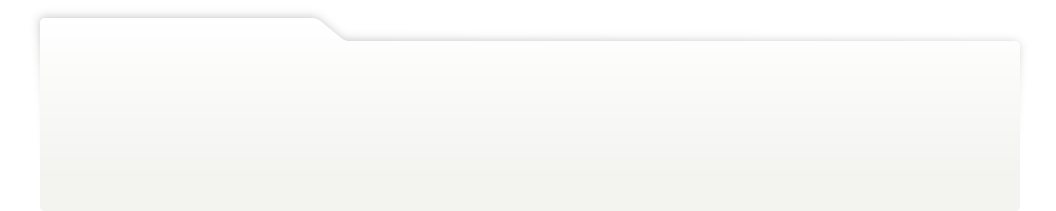
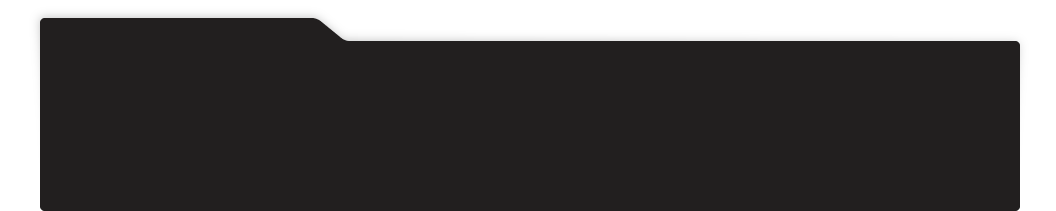
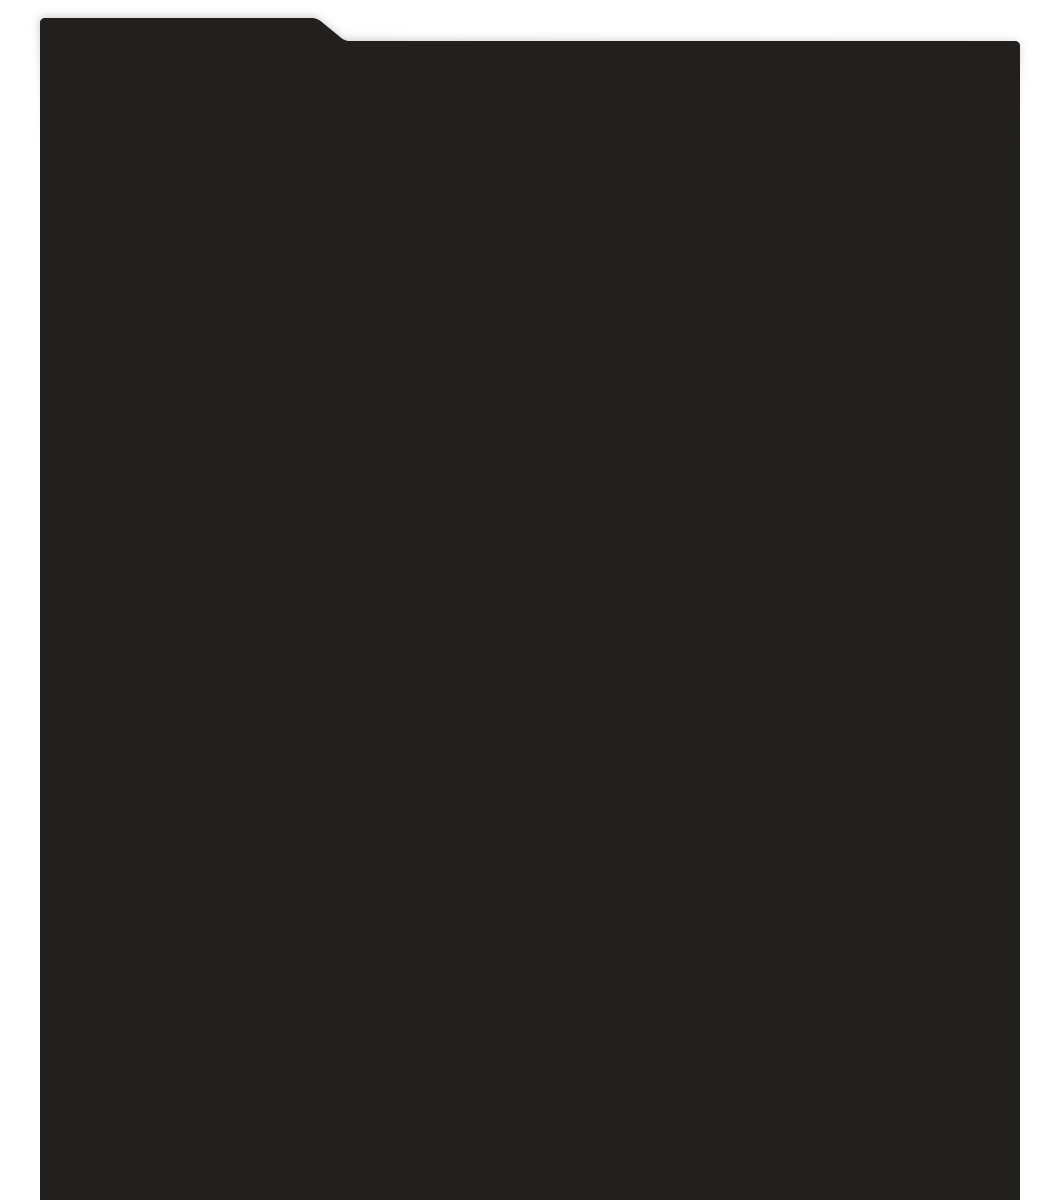
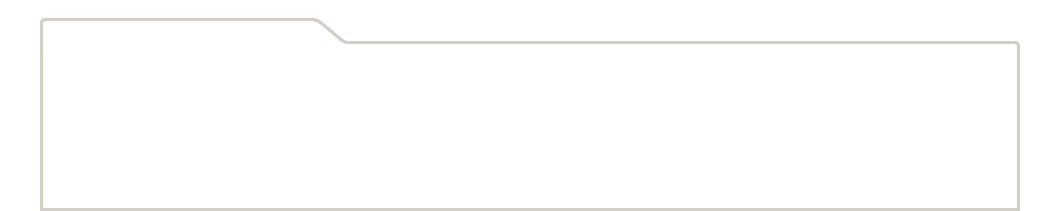
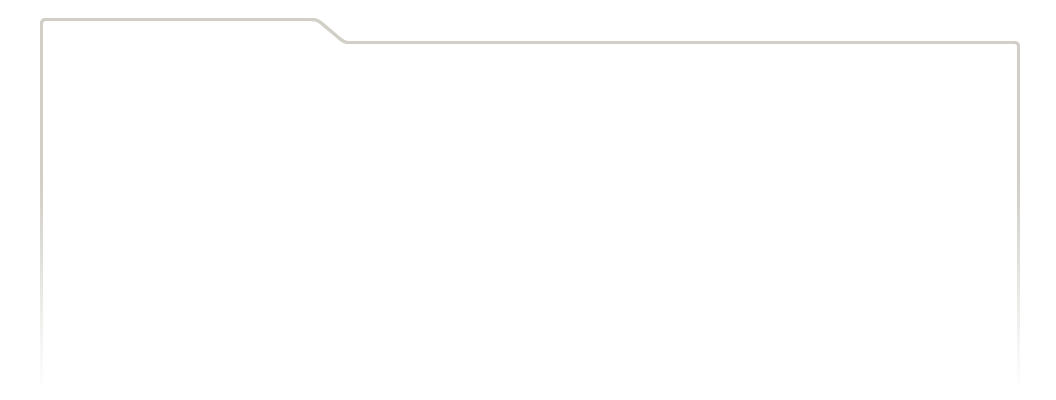
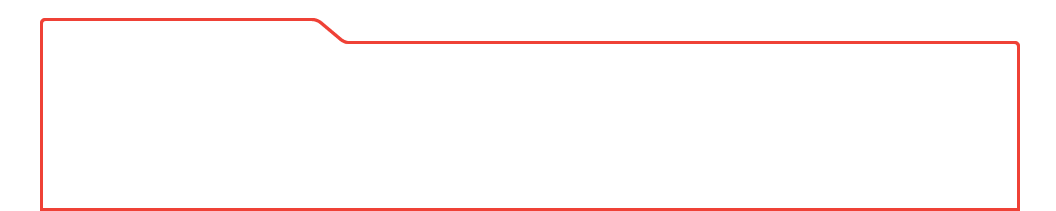
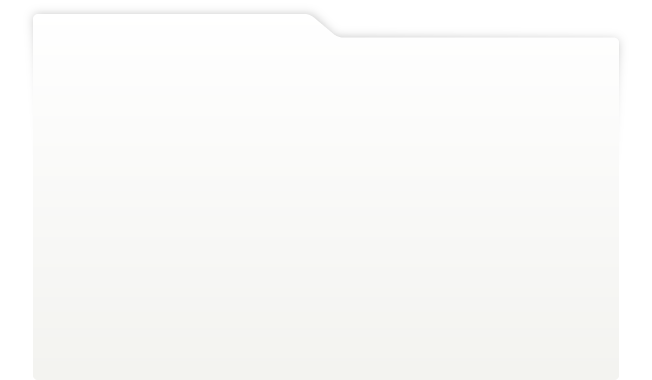
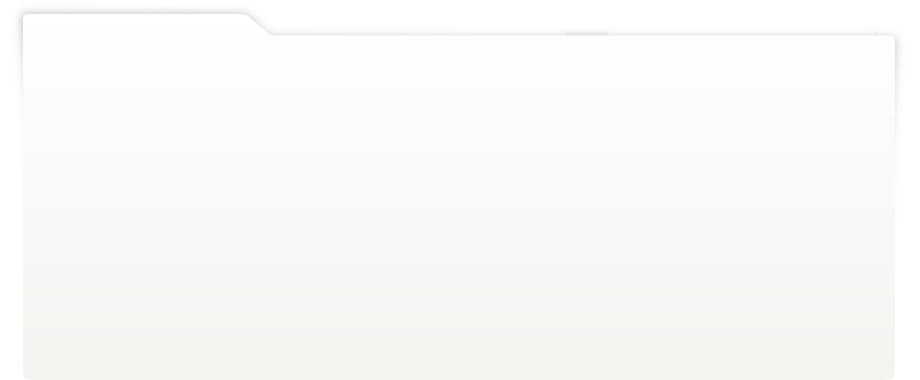
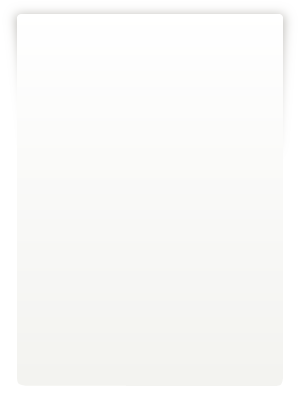
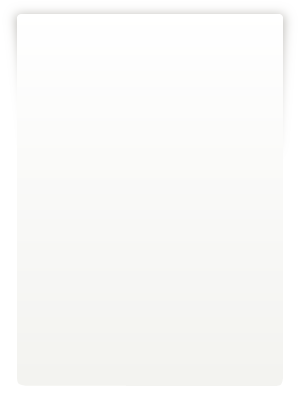
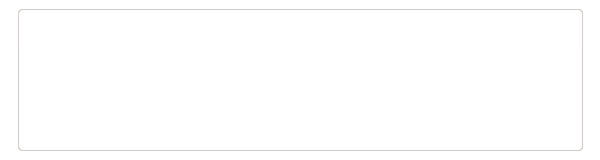
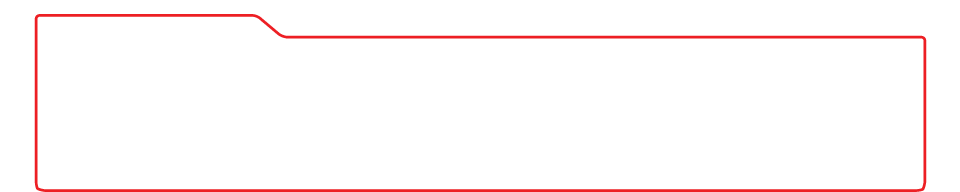
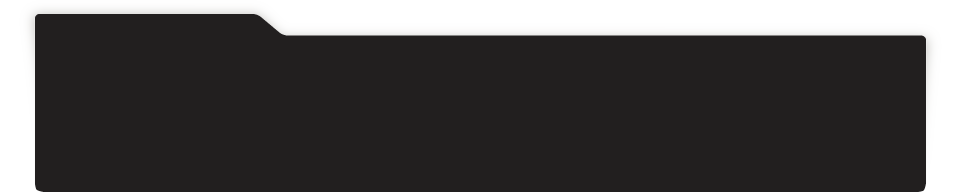
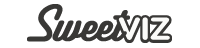
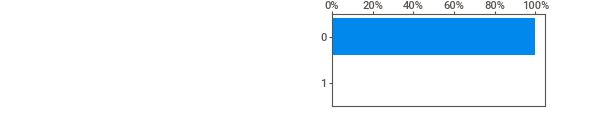
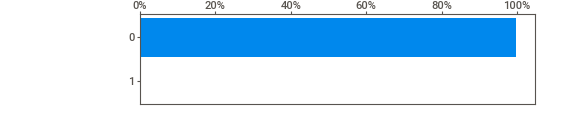
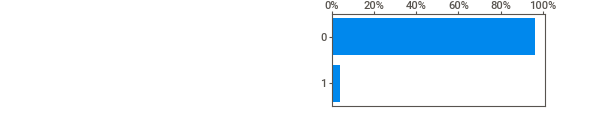
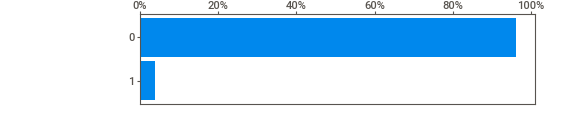
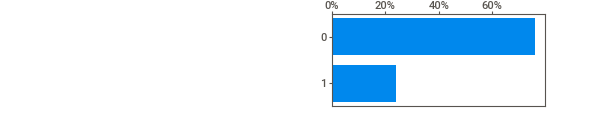
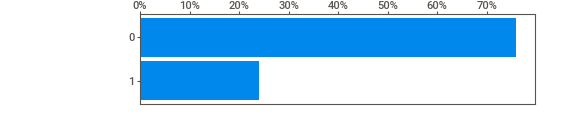
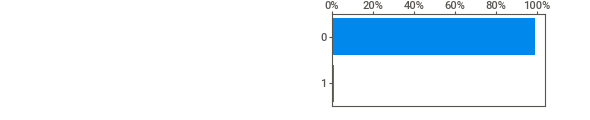
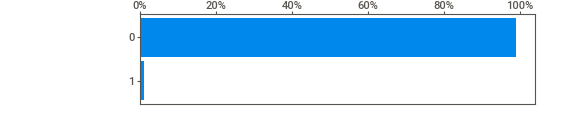
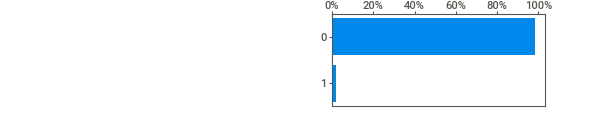
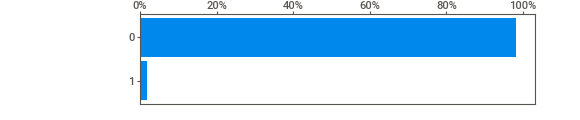
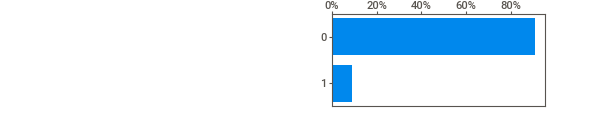
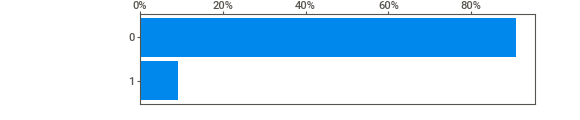
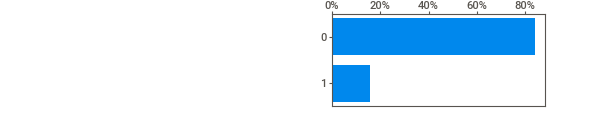
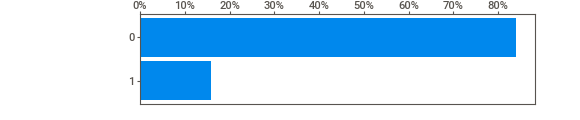
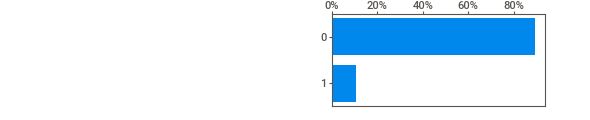
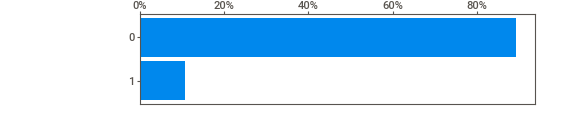
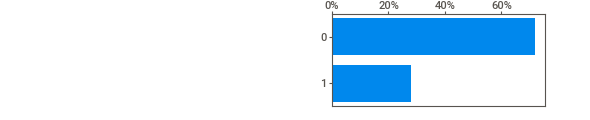
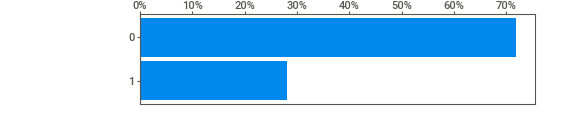
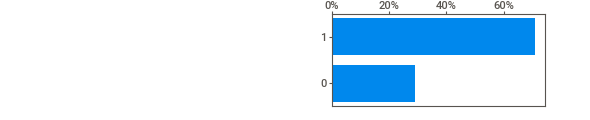
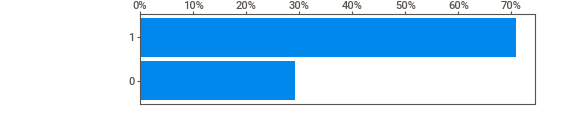
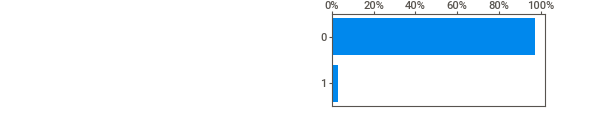
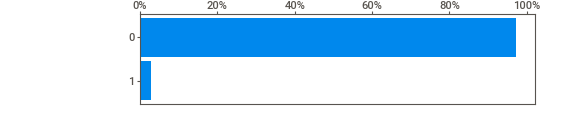
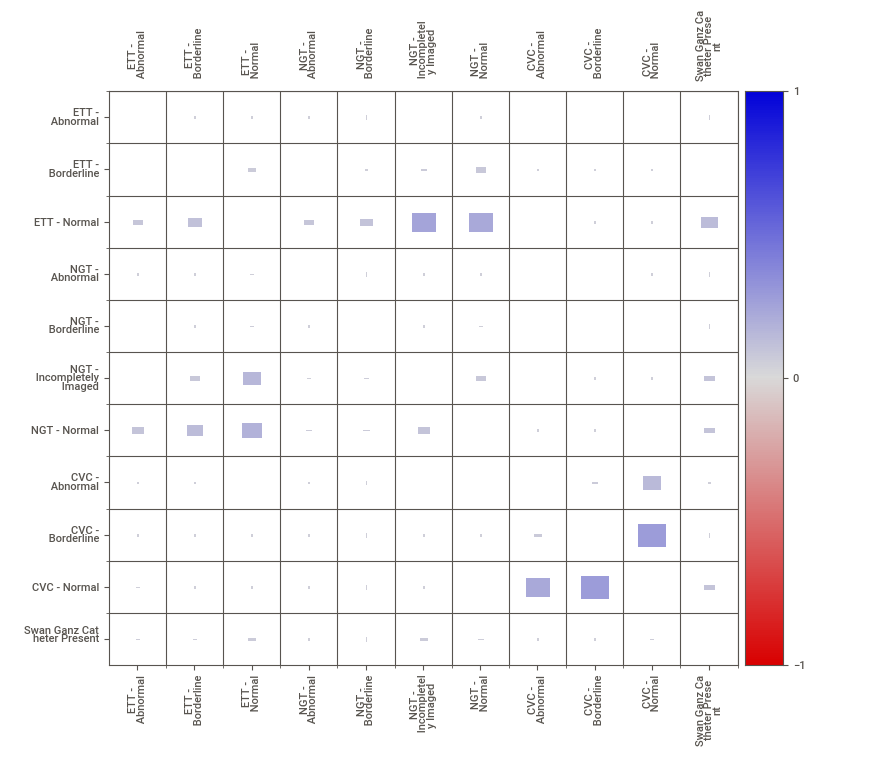
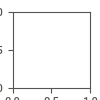

In [5]:
advert_report = sv.analyze(df)
advert_report.show_notebook()

In [6]:
label_cols = ['ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']

## shared catheter types in the same patient

### aggregating by catheter type

In [7]:
catheters = ['CVC', 'ETT' , 'NGT', 'Swan Ganz Catheter Present']
catheter_df = pd.DataFrame(index=df.index, columns=catheters)
labels = df.select_dtypes(int).columns
for catheter in catheters:
    group_cols = [label for label in labels if catheter in label]
    catheter_df[catheter] = df[group_cols].sum(axis=1) 

#### plotting by type

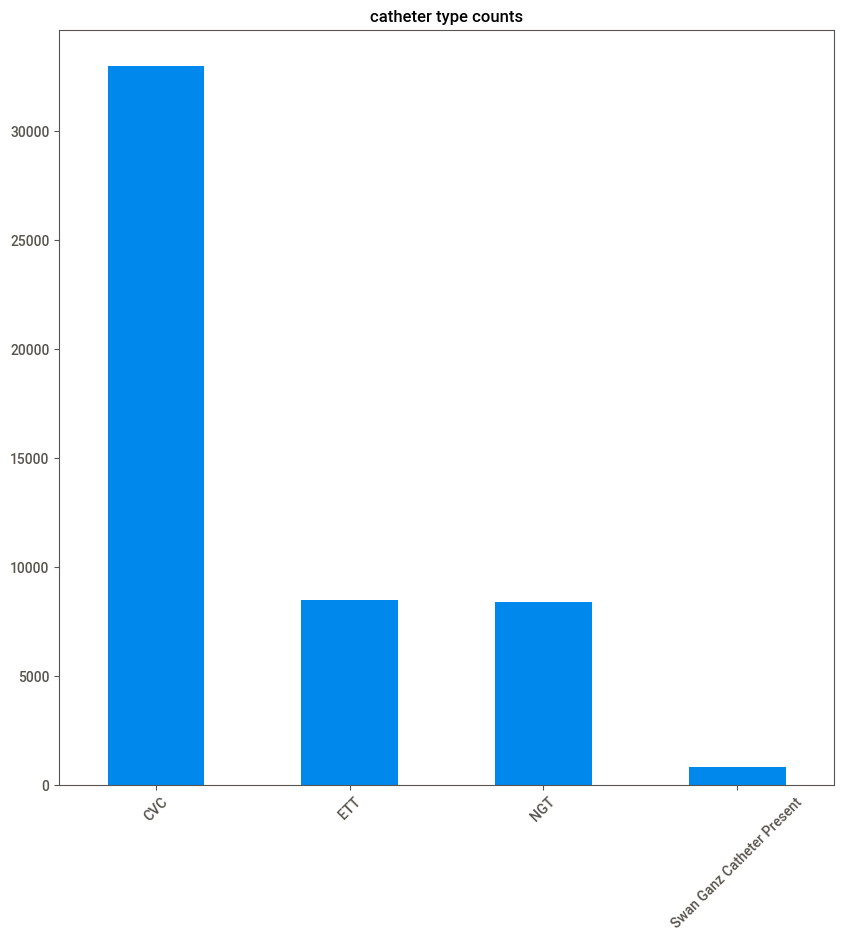

In [8]:
catheter_df.sum().plot(kind='bar', rot=45, figsize=(10,10), fontsize=10, title='catheter type counts')
plt.show()

#### frequency of multi-label records

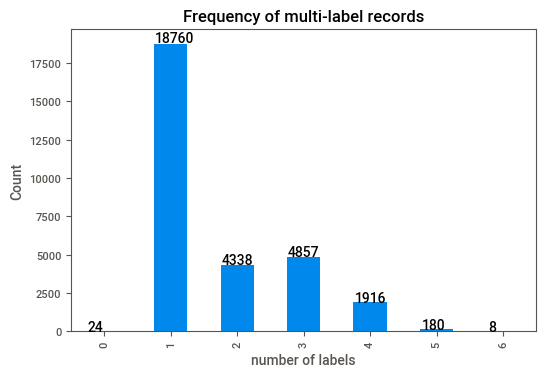

In [9]:
ax = catheter_df.sum(axis=1).value_counts().sort_index().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.xlabel('number of labels')
plt.ylabel('Count')
plt.title('Frequency of multi-label records')
plt.show()

#### binarizing type data frame 

In [108]:
catheter_df_bin = catheter_df.where(catheter_df == 0, 1) # if not 0 convert to 1

#### venn plots - multiple catheter  types in the same patient

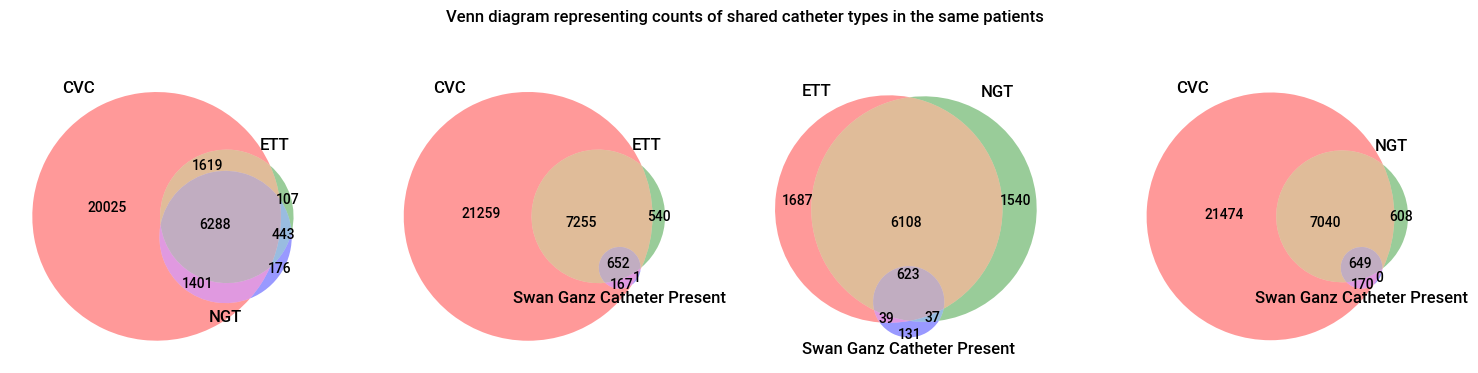

In [109]:
cat_trios = set(list(tuple(sorted(item)) for item in list(permutations(catheters, 3))))
_, axes = plt.subplots(ncols = len(cat_trios), figsize=(15, len(cat_trios)))
for ax, (group_a, group_b, group_c) in zip(axes, cat_trios):
    group_a_ser, group_b_ser, group_c_ser =  catheter_df_bin[group_a], catheter_df_bin[group_b], catheter_df_bin[group_c]
    group_a_only = np.sum((group_a_ser==1) & (group_b_ser == 0) & (group_c_ser == 0))
    group_b_only = np.sum((group_a_ser==0) & (group_b_ser == 1) & (group_c_ser == 0))
    group_c_only = np.sum((group_a_ser==0) & (group_b_ser == 0) & (group_c_ser == 1))
    group_a_and_b_only = np.sum((group_a_ser==1) & (group_b_ser == 1) & (group_c_ser == 0))
    group_a_and_c_only = np.sum((group_a_ser==1) & (group_b_ser == 0) & (group_c_ser == 1))
    group_b_and_c_only = np.sum((group_a_ser==0) & (group_b_ser == 1) & (group_c_ser == 1))
    intersection = np.sum((group_a_ser==1) & (group_b_ser == 1) & (group_c_ser == 1))
    venn3(
        subsets=(group_a_only, group_b_only, group_a_and_b_only, group_c_only, 
                 group_a_and_c_only, group_b_and_c_only, intersection), set_labels=(group_a, group_b, group_c), ax=ax)
plt.suptitle('Venn diagram representing counts of shared catheter types in the same patients')
plt.tight_layout()
plt.show()

#### plotting some samples

first making a function

In [110]:
def get_img(cond, ax, data: pd.DataFrame=df, title: str=''):
    img_path = str(Path(TRAIN_IMG_REL_DIR) / np.random.choice(data[cond][CASE].values)) + '.jpg'
    img = cv2.imread(str(img_path), cv2.COLOR_BGR2GRAY)
    ax.imshow(img, cmap='gray')
    ax.set_title(title)

#### only one type images

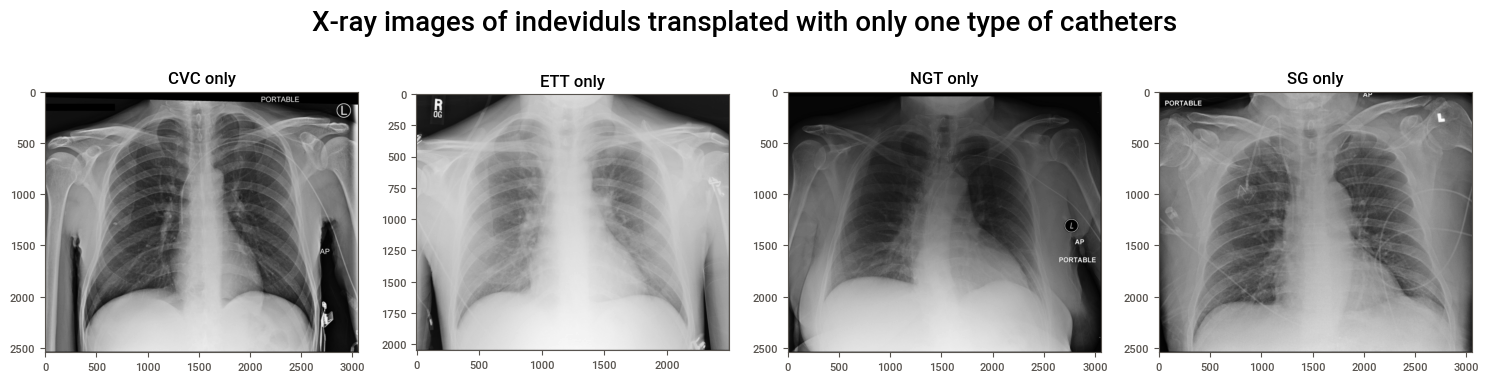

In [120]:
_, axes = plt.subplots(ncols = len(cat_trios), figsize=(15, len(cat_trios)))
only_cvc = (catheter_df_bin['CVC'] == 1) & (catheter_df_bin['ETT'] == 0) & (catheter_df_bin['NGT'] == 0) & (catheter_df_bin['Swan Ganz Catheter Present'] == 0)
only_ett = (catheter_df_bin['CVC'] == 0) & (catheter_df_bin['ETT'] == 1) & (catheter_df_bin['NGT'] == 0) & (catheter_df_bin['Swan Ganz Catheter Present'] == 0)
only_ngt = (catheter_df_bin['CVC'] == 0) & (catheter_df_bin['ETT'] == 0) & (catheter_df_bin['NGT'] == 1) & (catheter_df_bin['Swan Ganz Catheter Present'] == 0)
only_sg = (catheter_df_bin['CVC'] == 0) & (catheter_df_bin['ETT'] == 0) & (catheter_df_bin['NGT'] == 0) & (catheter_df_bin['Swan Ganz Catheter Present'] == 1)
get_img(only_cvc, axes[0], title='CVC only')
get_img(only_cvc, axes[1], title='ETT only')
get_img(only_cvc, axes[2], title='NGT only')
get_img(only_cvc, axes[3], title='SG only')
plt.suptitle('X-ray images of individuals transplanted with only one type of catheters', fontsize=20)
plt.tight_layout()

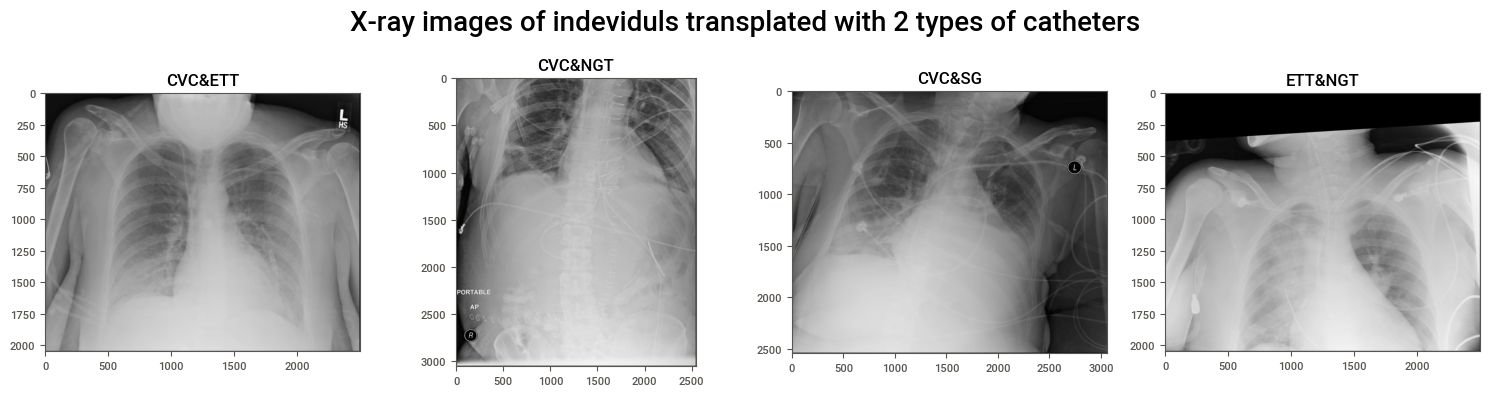

In [125]:
_, axes = plt.subplots(ncols = len(cat_trios), figsize=(15, len(cat_trios)))
cvc_ett = (catheter_df_bin['CVC'] == 1) & (catheter_df_bin['ETT'] == 1) & (catheter_df_bin['NGT'] == 0) & (catheter_df_bin['Swan Ganz Catheter Present'] == 0)
cvc_ngt = (catheter_df_bin['CVC'] == 1) & (catheter_df_bin['ETT'] == 0) & (catheter_df_bin['NGT'] == 1) & (catheter_df_bin['Swan Ganz Catheter Present'] == 0)
cvc_sg = (catheter_df_bin['CVC'] == 1) & (catheter_df_bin['ETT'] == 0) & (catheter_df_bin['NGT'] == 0) & (catheter_df_bin['Swan Ganz Catheter Present'] == 1)
ett_ngt = (catheter_df_bin['CVC'] == 0) & (catheter_df_bin['ETT'] == 1) & (catheter_df_bin['NGT'] == 1) & (catheter_df_bin['Swan Ganz Catheter Present'] == 0)

get_img(only_cvc, axes[0], title='CVC&ETT')
get_img(cvc_ngt, axes[1], title='CVC&NGT')
get_img(cvc_sg, axes[2], title='CVC&SG')
get_img(ett_ngt, axes[3], title='ETT&NGT')

plt.suptitle('X-ray images of individuals transplanted with 2 types of catheters', fontsize=20)
plt.tight_layout()
plt.show()

#### intersect images

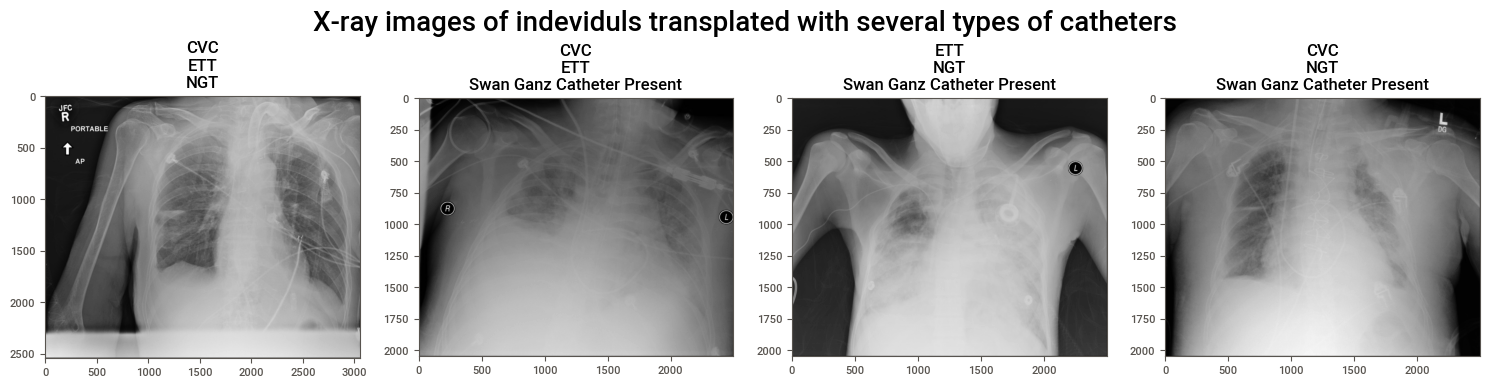

In [111]:
_, axes = plt.subplots(ncols = len(cat_trios), figsize=(15, len(cat_trios)))
for ax, (group_a, group_b, group_c) in zip(axes, cat_trios):
    group_a_ser, group_b_ser, group_c_ser =  catheter_df_bin[group_a], catheter_df_bin[group_b], catheter_df_bin[group_c]
    title = '\n'.join([group_a, group_b, group_c])
    cond = (group_a_ser == group_b_ser) & (group_a_ser == group_c_ser)
    get_img(cond, ax, title=title)
plt.suptitle('X-ray images of individuals transplanted with several types of catheters', fontsize=20)
plt.tight_layout()

#### all 4

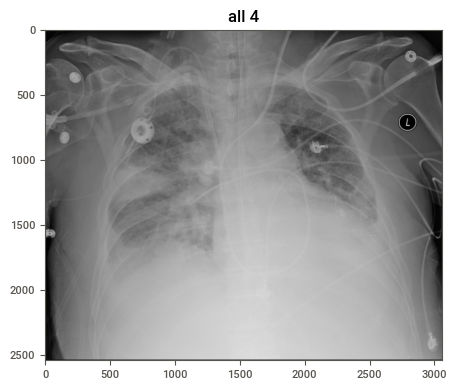

In [130]:
_, axes = plt.subplots(ncols = 1, nrows=1, figsize=(15, len(cat_trios)))
cond = (catheter_df_bin['CVC'] == 1) & (catheter_df_bin['ETT'] == 1) & (catheter_df_bin['NGT'] == 1) & (catheter_df_bin['Swan Ganz Catheter Present'] == 1)
get_img(cond, axes, title='all 4')
plt.tight_layout()
plt.show()

### divide by catheter type

#### helper function

In [102]:
def make_sets3(cols: list):
    group_a, group_b, group_c = cols
    group_a_ser, group_b_ser, group_c_ser =  df[group_a], df[group_b], df[group_c]
    group_a_only = np.sum((group_a_ser==1) & (group_b_ser == 0) & (group_c_ser == 0))
    group_b_only = np.sum((group_a_ser==0) & (group_b_ser == 1) & (group_c_ser == 0))
    group_c_only = np.sum((group_a_ser==0) & (group_b_ser == 0) & (group_c_ser == 1))
    group_a_and_b_only = np.sum((group_a_ser==1) & (group_b_ser == 1) & (group_c_ser == 0))
    group_a_and_c_only = np.sum((group_a_ser==1) & (group_b_ser == 0) & (group_c_ser == 1))
    group_b_and_c_only = np.sum((group_a_ser==0) & (group_b_ser == 1) & (group_c_ser == 1))
    intersection = np.sum((group_a_ser==1) & (group_b_ser == 1) & (group_c_ser == 1))
    return (group_a_only, group_b_only, group_a_and_b_only, group_c_only, 
                 group_a_and_c_only, group_b_and_c_only, intersection), (group_a, group_b, group_c)

#### CVC

In [103]:
cvc_cols = [cvc_col for cvc_col in df.columns if 'CVC' in cvc_col]

In [104]:
sets, labels = make_sets3(cvc_cols)

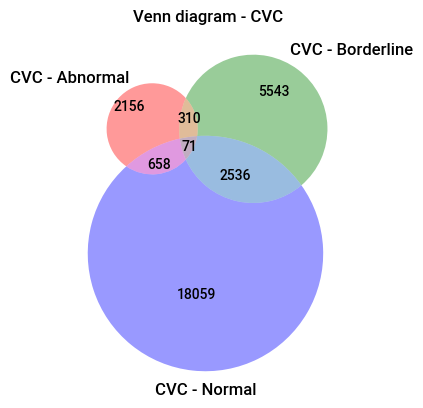

In [105]:
venn3(subsets=sets, set_labels=labels)
plt.tight_layout()
plt.title('Venn diagram - CVC')
plt.show()

#### ETT

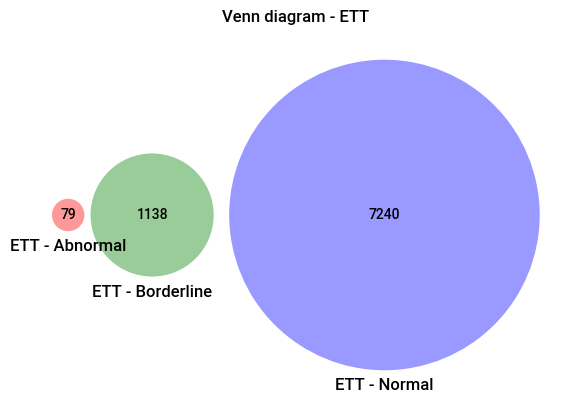

In [106]:
ett_cols = [cvc_col for cvc_col in df.columns if 'ETT' in cvc_col]
sets, labels = make_sets3(ett_cols)
venn3(subsets=sets, set_labels=labels)
plt.tight_layout()
plt.title('Venn diagram - ETT')
plt.show()

#### EGT

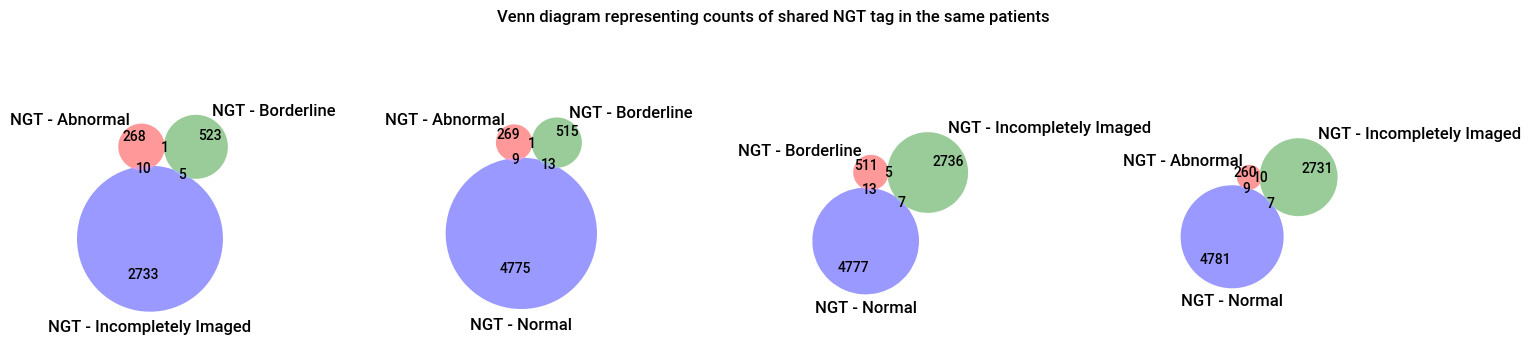

In [117]:
ngt_cols = [cvc_col for cvc_col in df.columns if 'NGT' in cvc_col]
ngt_trios = set(list(tuple(sorted(item)) for item in list(permutations(ngt_cols, 3))))
_, axes = plt.subplots(ncols = len(ngt_trios), figsize=(15, len(cat_trios)))
for ax, trio in zip(axes, ngt_trios):
    sets, labels = make_sets3(trio)
    venn3(subsets=sets, set_labels=labels, ax=ax)
plt.suptitle('Venn diagram representing counts of shared NGT tag in the same patients')
plt.tight_layout()
plt.show()

# EDA over images

## get distribution of size

In [142]:
shape_lst = []
for jpg in Path(TRAIN_IMG_REL_DIR).glob('*jpg'):
    img = cv2.imread(str(jpg), cv2.COLOR_BGR2GRAY)
    shape_lst.append(img.shape)

### general and frequent info

In [171]:
size_df = pd.DataFrame(shape_lst, columns=['height', 'width'])
size_df.describe()

,height,width
count,30083.000000,30083.000000
mean,2346.374298,2683.915766
std,349.252643,297.273613
min,1561.000000,1496.000000
25%,2048.000000,2500.000000
50%,2048.000000,2500.000000
75%,2544.000000,3056.000000
max,3567.000000,3827.000000


### height and width distribution

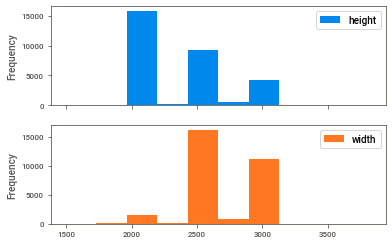

In [172]:
size_df.plot(kind='hist', subplots=True)
plt.show()

In [160]:
print('shortest: {}, longest: {}'.format(sorted(shape_lst)[0], sorted(shape_lst)[-1]))

shortest: (1561, 1702), longest: (3567, 3827)
